In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy.stats import norm
import mpld3

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Consider a simple first order Hidden Markov model. 
Immagine a moving object in 1-D where $x_k$ is position of the said object at moment $k$. 

$x_{k+1} = v + x_{k} + n_k$, 

$y_k = x_k + m_k$

Here $x_k$ is hidden state and $y_k$ is observation, and $v$ is velocity.

$n_k \sim \mathcal{N}(0, \sigma_n^2)$ is state noise.

$m_k \sim \mathcal{N}(0, \sigma_m^2)$ is measurement noise.

This can be graphically represented as: 

        x_{k-1} ---> x_{k} ---> x_{k+1} ---> ....
            |          |            | 
            V          V            V    
         y_{k-1}     y_{k}         y_{k+1}
         
Task: Given observations $y_k$ and model structure  above, estimate velocity $v$. 

In [2]:
"""Generate data: 30 points, set velocity to 0.5, choose some initial state x, 
generate state and measurement noise, plot the resutlts"""

N = 30; ## Number of data points
vel = 0.5 ## Velocity
x = 0.1;  ## Initial state
true_positions = np.zeros(N);  ## Initialise vector to hold measurents y_k

true_positions[0] = x
n = 0.05*norm.rvs(size=N) # State noise



for i in range(1,N):
    x = vel + x + n[i]
    true_positions[i] = x

scale_m_noise = 0.5 # Measurement noise
    
true_positions = true_positions +scale_m_noise*norm.rvs(size=N) 

plt.plot(true_positions)
plt.grid()
plt.xlabel('Time index k')
plt.ylabel('Position y_k')
mpld3.display()

In [3]:
model = pm.Model()

with model:


    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)

    some_tau = BoundedNormal("state_noise_scale", mu=0.1,sd=0.1)
    some_tau_output = BoundedNormal("measurement_noise_scale", mu=0.1,sd=0.1)

    vel = pm.Normal("vel", mu=0, tau=5) ## Velocity is  a parameter we wish to infere

    # MODEL
    states = [pm.Normal("s0", mu=true_positions[0], sd=some_tau)]
    for i in range(1, len(true_positions)):
        states.append(pm.Normal(name="s" + str(i),
                                mu=states[-1] + vel,
                                sd=some_tau))

    # Condition model on observations 
    obs = pm.Normal("obs", mu=states, sd=some_tau_output, observed=true_positions)

In [4]:
"""Initialise sample and sample from posterior"""
Nchain = 1000; 
with model:
#     start = pm.find_MAP()
    step = pm.Slice()
#     trace = pm.sample(Nchain, step=step, start=start, cores=8);
    trace = pm.sample(Nchain, step=step, cores=8);

Multiprocess sampling (8 chains in 8 jobs)
CompoundStep
>Slice: [s29]
>Slice: [s28]
>Slice: [s27]
>Slice: [s26]
>Slice: [s25]
>Slice: [s24]
>Slice: [s23]
>Slice: [s22]
>Slice: [s21]
>Slice: [s20]
>Slice: [s19]
>Slice: [s18]
>Slice: [s17]
>Slice: [s16]
>Slice: [s15]
>Slice: [s14]
>Slice: [s13]
>Slice: [s12]
>Slice: [s11]
>Slice: [s10]
>Slice: [s9]
>Slice: [s8]
>Slice: [s7]
>Slice: [s6]
>Slice: [s5]
>Slice: [s4]
>Slice: [s3]
>Slice: [s2]
>Slice: [s1]
>Slice: [s0]
>Slice: [vel]
>Slice: [measurement_noise_scale]
>Slice: [state_noise_scale]
Sampling 8 chains: 100%|██████████| 12000/12000 [01:56<00:00, 20.02draws/s] 
The estimated number of effective samples is smaller than 200 for some parameters.


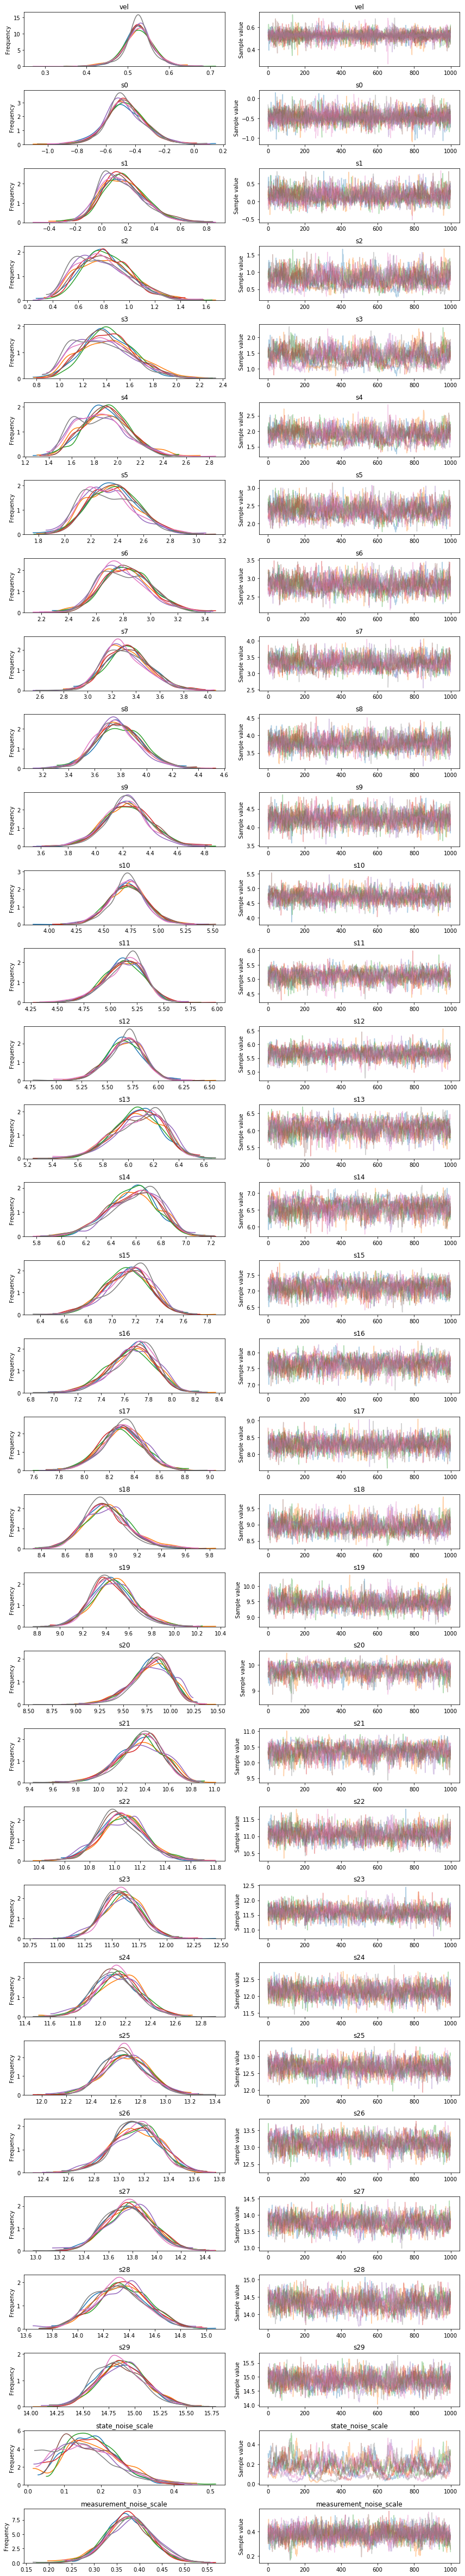

In [5]:
pm.traceplot(trace)
plt.show()

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(trace['vel'])
plt.ylabel('Velocity')
plt.xlabel('Sample')

plt.subplot(1,2,2)
n, bins, patches = plt.hist(trace['vel'], 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Velocity')
plt.ylabel('Probability')
plt.title('Histogram of velocity trace')
plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.axis([40, 160, 0, 0.03])
plt.grid(True)
mpld3.display()